In [1]:
import json, glob, re, pycm, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, scipy.stats as stats
from IPython.display import display, Markdown

In [89]:
def unilateral_truth_value(verifications, n=1):
    pattern = r'\b(TRUE|FALSE)\b'
    matches = [ re.findall(pattern, verification) for verification in verifications[:n] ]
    results = [ match[-1] if match else 'NOT ATTEMPTED' for match in matches ]
    result = max(set(results), key=results.count)
    if result == 'TRUE':
        return 't'
    elif result == 'FALSE':
        return 'f'
    else:
        return 'n'


In [90]:
def bilateral_truth_value(verifications, refutations, n=1):
    pattern = r'\b(VERIFIED|CANNOT VERIFY|REFUTED|CANNOT REFUTE)\b'
    v_matches = [ re.findall(pattern, verification) for verification in verifications[:n] ]
    r_matches = [ re.findall(pattern, refutation) for refutation in refutations[:n] ]
    verification_results = [ match[-1] if match else 'CANNOT VERIFY' for match in v_matches ]
    refutation_results = [ match[-1] if match else 'CANNOT REFUTE' for match in r_matches ]
    verification_result = max(set(verification_results), key=verification_results.count)
    refutation_result = max(set(refutation_results), key=refutation_results.count)
    if verification_result == 'VERIFIED':
        if refutation_result == 'REFUTED':
            return 'b'
        else:
            return 't'
    else:
        if refutation_result == 'REFUTED':
            return 'f'
        else:
            return 'n'

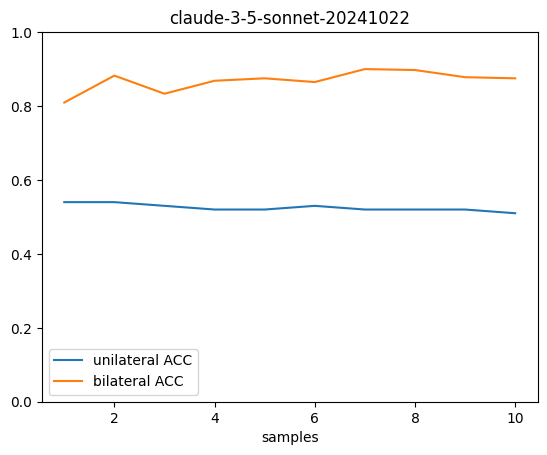

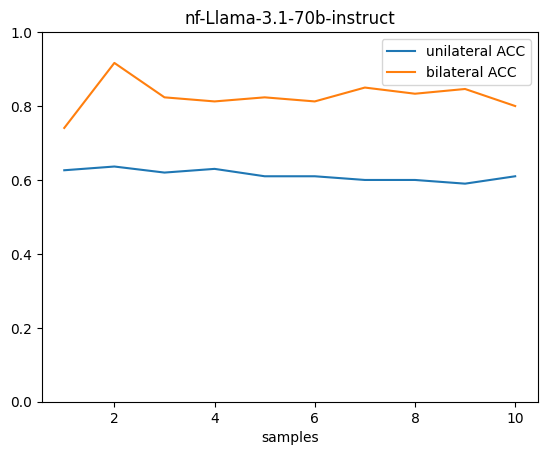

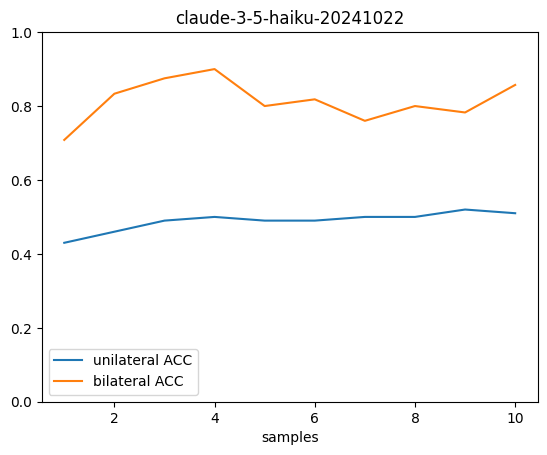

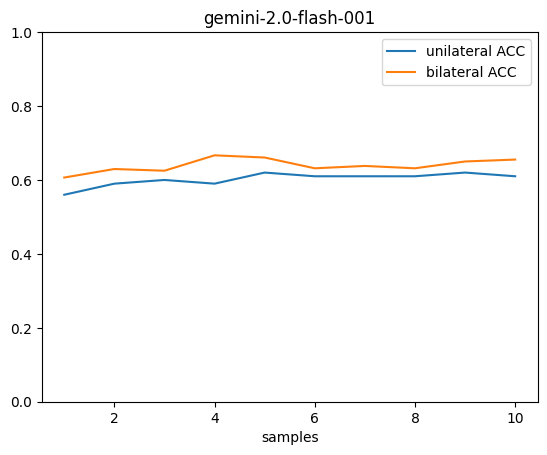

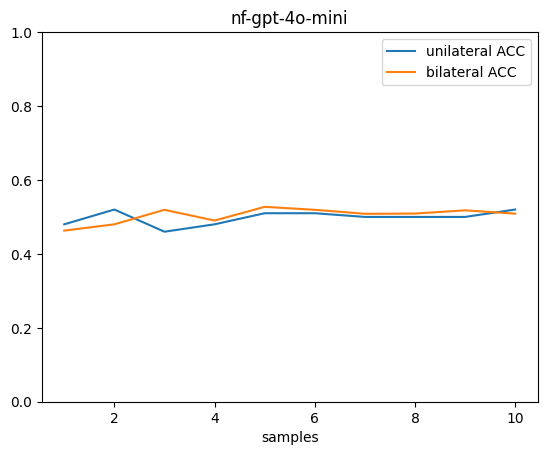

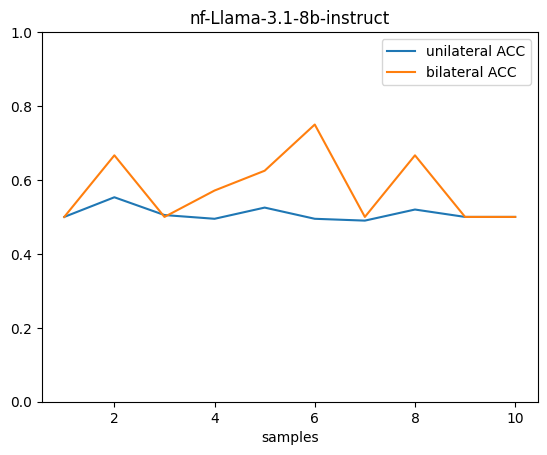

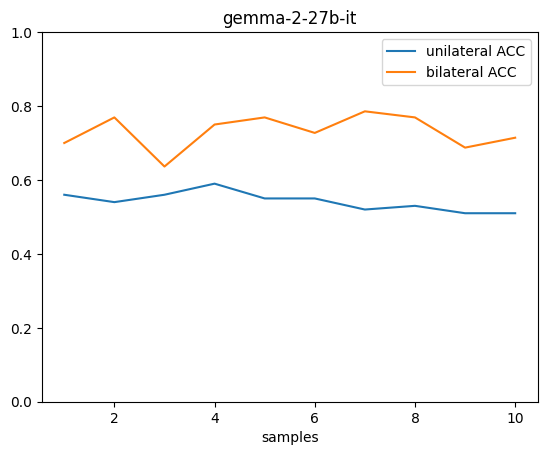

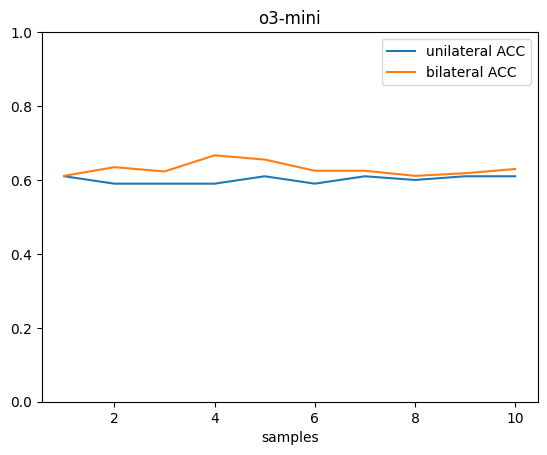

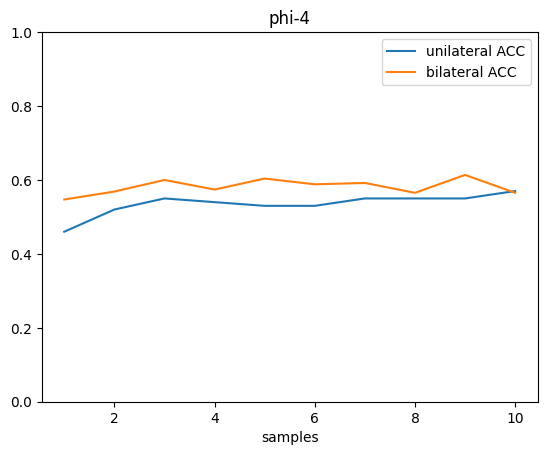

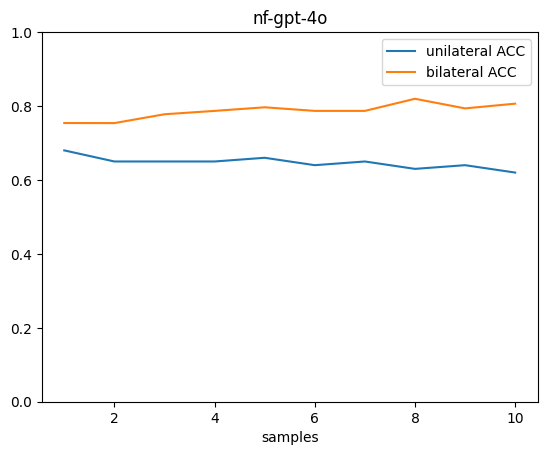

In [109]:
for file in glob.glob(f"experiments/v12/unilateral/*.json"):
    model = re.match(r'.*/unilateral/(.*)-simpleqa.json', file).group(1)
    uni_results = json.load(open(f"experiments/v12/unilateral/{model}-simpleqa.json", "r"))
    bi_results = json.load(open(f"experiments/v12/bilateral/{model}-simpleqa.json", "r"))
    labels = [ result['label'] for result in uni_results ]
    uni_evals_per_n_samples = [ [ unilateral_truth_value(result['reasoning'], i+1) for i in range(len(result['reasoning']))] for result in uni_results ]
    bi_evals_per_n_samples = [ [ bilateral_truth_value(result['verification'],result['refutation'], i+1) for i in range(len(result['verification']))] for result in bi_results ]
    uni_evals = np.array(uni_evals_per_n_samples).T.tolist()
    bi_evals = np.array(bi_evals_per_n_samples).T.tolist()
    pd.DataFrame([ 
        [i+1, pycm.ConfusionMatrix(labels,uni_evals[i], digit=2, classes=[ 't', 'f' ]).ACC_Macro, pycm.ConfusionMatrix(labels,bi_evals[i], digit=2, classes=[ 't', 'f' ]).ACC_Macro] for i in range(10) ], 
        columns=["samples", "unilateral ACC", "bilateral ACC"]).plot(
            title=model,
            kind='line', 
            x='samples', 
            y=['unilateral ACC', 'bilateral ACC'], 
            ylim=(0.0, 1.0))